# Install required packages

In [1]:
!pip install -r requirements.txt

In [2]:
# Import packages
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from sklearn.metrics import r2_score
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay

In [3]:
sns.set_theme()

In [4]:
# Set seed
np.random.seed(0)

# Prepare RF training and test sets

In [ ]:
# Getting the gpkg from 

In [ ]:
# Read observation data
fp = "agile2024_tn_mean_obs_sites.gpkg"
obs_data = gpd.read_file(fp)
display(obs_data)

,site_code,obs_id,obs_value,arable_prop,arable_prop_buff_100,arable_prop_buff_1000,arable_prop_buff_500,area,awc1_min,awc1_max,...,tri_mean,tri_std,twi_min,twi_max,twi_mean,twi_std,urban_prop,water_prop,wetland_prop,geometry
0,SJA8127000,161,1.0288,0.086,0.175,0.092,0.124,1.512569e+08,0.178,0.212,...,0.119,0.176,2.206,14.725,9.732,1.706,0.006,0.005,0.129,POINT (696315.000 6546937.000)
1,SJA9900000,200,1.3402,0.182,0.170,0.178,0.190,8.071414e+08,0.173,0.215,...,0.100,0.191,1.725,15.356,9.827,1.375,0.026,0.008,0.087,POINT (669868.000 6591973.000)
2,SJA3956000,90,6.6156,0.536,0.340,0.520,0.464,4.229881e+08,0.169,0.207,...,0.112,0.150,1.869,15.563,9.910,1.513,0.049,0.003,0.006,POINT (636008.000 6603086.000)
3,SJA1934000,40,1.6676,0.243,0.134,0.172,0.156,2.132077e+08,0.173,0.211,...,0.109,0.183,1.842,14.976,9.745,1.348,0.056,0.004,0.014,POINT (700294.000 6592517.000)
4,SJA7837000,157,2.8696,0.293,0.321,0.330,0.352,3.100426e+08,0.173,0.208,...,0.111,0.151,1.859,15.576,9.724,1.397,0.111,0.007,0.058,POINT (520653.000 6588232.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,SJB3503000,238,8.2250,0.537,0.316,0.523,0.453,1.122941e+08,0.174,0.205,...,0.099,0.111,2.279,15.563,10.033,1.392,0.028,0.002,0.014,POINT (633230.000 6585334.000)
235,SJA3731000,84,1.7250,0.200,0.065,0.122,0.085,6.085978e+07,0.175,0.206,...,0.124,0.223,1.842,14.565,9.663,1.395,0.072,0.003,0.009,POINT (698754.000 6586118.000)
236,SJA0813000,17,3.2500,0.452,0.223,0.499,0.475,4.023375e+07,0.174,0.207,...,0.207,0.272,2.373,16.631,9.019,2.097,0.033,0.007,0.014,POINT (619933.000 6581023.000)
237,SJA8884000,175,3.3000,0.242,0.176,0.232,0.225,1.930663e+09,0.164,0.218,...,0.105,0.145,1.464,15.329,9.728,1.468,0.025,0.010,0.106,POINT (551221.000 6591443.000)


In [6]:
obs_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 86 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   site_code                      239 non-null    object  
 1   obs_id                         239 non-null    int64   
 2   obs_value                      239 non-null    float64 
 3   arable_prop                    239 non-null    float64 
 4   arable_prop_buff_100           239 non-null    float64 
 5   arable_prop_buff_1000          239 non-null    float64 
 6   arable_prop_buff_500           239 non-null    float64 
 7   area                           239 non-null    float64 
 8   awc1_min                       239 non-null    float64 
 9   awc1_max                       239 non-null    float64 
 10  awc1_mean                      239 non-null    float64 
 11  awc1_std                       239 non-null    float64 
 12  bd1_min                     

In [7]:
# Create interactive plot of observation values
obs_data.explore(
    column="obs_value",
    cmap="YlOrRd",
    tooltip=["site_code", "obs_value"],
    marker_kwds={"radius": 4},
    style_kwds={"color": "black", "weight": 1, "fillOpacity": 0.9}
)

In [8]:
# Extract features and target
X = obs_data.iloc[:, 3:-1]
y = obs_data["obs_value"]

In [9]:
# Split the data into training and test sets
test_size = 0.3
random_state = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [10]:
X_train

,arable_prop,arable_prop_buff_100,arable_prop_buff_1000,arable_prop_buff_500,area,awc1_min,awc1_max,awc1_mean,awc1_std,bd1_min,...,tri_max,tri_mean,tri_std,twi_min,twi_max,twi_mean,twi_std,urban_prop,water_prop,wetland_prop
66,0.514,0.281,0.441,0.338,1.063248e+08,0.170,0.206,0.191,0.005,0.419,...,6.367,0.121,0.153,2.028,15.311,9.805,1.595,0.062,0.001,0.000
26,0.106,0.125,0.187,0.188,1.764045e+09,0.145,0.214,0.189,0.005,0.373,...,4.707,0.205,0.233,1.908,16.318,8.630,1.894,0.009,0.006,0.031
76,0.295,0.148,0.300,0.284,3.705538e+07,0.167,0.213,0.193,0.006,0.379,...,4.070,0.306,0.253,2.214,14.906,7.720,1.987,0.024,0.039,0.042
217,0.115,0.062,0.097,0.095,7.369312e+07,0.173,0.202,0.190,0.004,0.409,...,3.800,0.119,0.196,2.285,14.477,9.711,1.647,0.010,0.003,0.117
212,0.001,0.000,0.002,0.001,2.029442e+07,0.175,0.198,0.188,0.004,0.421,...,2.722,0.092,0.159,2.664,14.269,10.261,1.611,0.002,0.003,0.191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.494,0.000,0.020,0.000,8.710658e+07,0.170,0.206,0.192,0.006,0.419,...,3.070,0.120,0.148,2.028,15.311,9.791,1.587,0.049,0.001,0.000
192,0.035,0.001,0.006,0.001,3.642620e+07,0.175,0.200,0.187,0.004,0.408,...,3.177,0.134,0.179,1.859,14.493,9.359,1.400,0.340,0.006,0.045
117,0.283,0.226,0.290,0.293,5.315514e+09,0.160,0.220,0.193,0.006,0.371,...,922.779,0.098,0.157,0.157,15.942,9.829,1.346,0.020,0.007,0.083
47,0.298,0.244,0.320,0.319,1.045249e+09,0.000,0.213,0.190,0.006,0.371,...,4.663,0.209,0.224,1.909,16.221,8.650,1.896,0.029,0.017,0.025


In [11]:
y_train

66     7.583333
26     1.008000
76     0.835000
217    2.421500
212    1.362000
         ...   
67     6.609000
192    1.285000
117    1.380000
47     1.855000
172    3.975000
Name: obs_value, Length: 167, dtype: float64

# Hyperparameter tuning

In [12]:
# Search for hyperparameters
def search_hyperparams(X, y, random_state):

    # Number of trees in random forest
    n_estimators = list(np.linspace(start=10, stop=100, num=10, dtype=int))

    # Number of features to consider at every split
    max_features = [1, "sqrt", "log2"]

    # Maximum number of levels in tree
    max_depth = list(np.linspace(start=10, stop=100, num=10, dtype=int))
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create dictionary from parameters
    param_distributions = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "bootstrap": bootstrap
    }

    # Perform search for hyperparameters
    estimator = RandomForestRegressor()
    rf_random = RandomizedSearchCV(
        estimator=estimator, param_distributions=param_distributions, n_iter=100, verbose=2, random_state=random_state,
        n_jobs=-1
    )
    rf_random.fit(X, y)

    # Get best parameters
    params = rf_random.best_params_
    params["bootstrap"] = True
    params["oob_score"] = True

    return params

In [13]:
%%time

# Perform search for hyperparameters
params = search_hyperparams(X_train, y_train, random_state)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 1.63 s, sys: 212 ms, total: 1.85 s
Wall time: 1min 7s


# Train model

In [14]:
# RF regressor
regressor = RandomForestRegressor()

In [15]:
# Set hyperparameters
regressor.set_params(**params)

RandomForestRegressor(max_depth=60, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=70, oob_score=True)

In [16]:
# Fit model
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=60, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=70, oob_score=True)

In [17]:
# Calculate accuracy on training set
regressor.score(X_train, y_train)

0.8873583818854893

In [18]:
# Predict
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

In [19]:
# Calculate accuracy on test set
r2_score(y_test, Y_test_pred)

0.65262315827182

# Calculate SHAP values

In [20]:
# Calculate SHAP values
explainer = shap.TreeExplainer(regressor)
shap_values = shap.TreeExplainer(regressor).shap_values(X_train)

In [21]:
shap_values

array([[ 0.55816795,  0.24421313,  0.06669115, ...,  0.04130212,
         0.10980012,  0.28467886],
       [-0.15224423, -0.05316249, -0.07000528, ..., -0.01254629,
        -0.03075509, -0.02057845],
       [-0.06705953, -0.0692273 , -0.03092006, ..., -0.01054639,
        -0.04237973, -0.02256129],
       ...,
       [-0.04871144, -0.02947386, -0.03252725, ...,  0.00406708,
        -0.02793948, -0.02593945],
       [-0.0395526 , -0.01721452, -0.02563818, ...,  0.01194115,
        -0.03454448, -0.01107294],
       [ 0.03854434,  0.11147976,  0.04963378, ...,  0.00788748,
        -0.00162879, -0.03926169]])

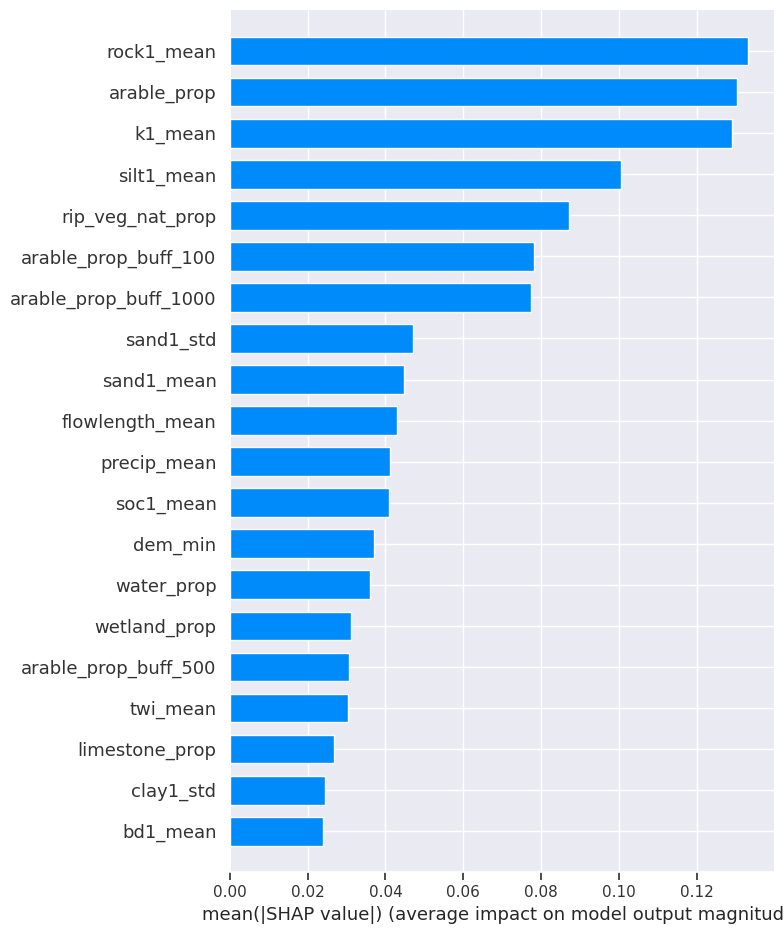

<Figure size 640x480 with 0 Axes>

In [22]:
# SHAP summary bar plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns, plot_type="bar")
plt.tight_layout()

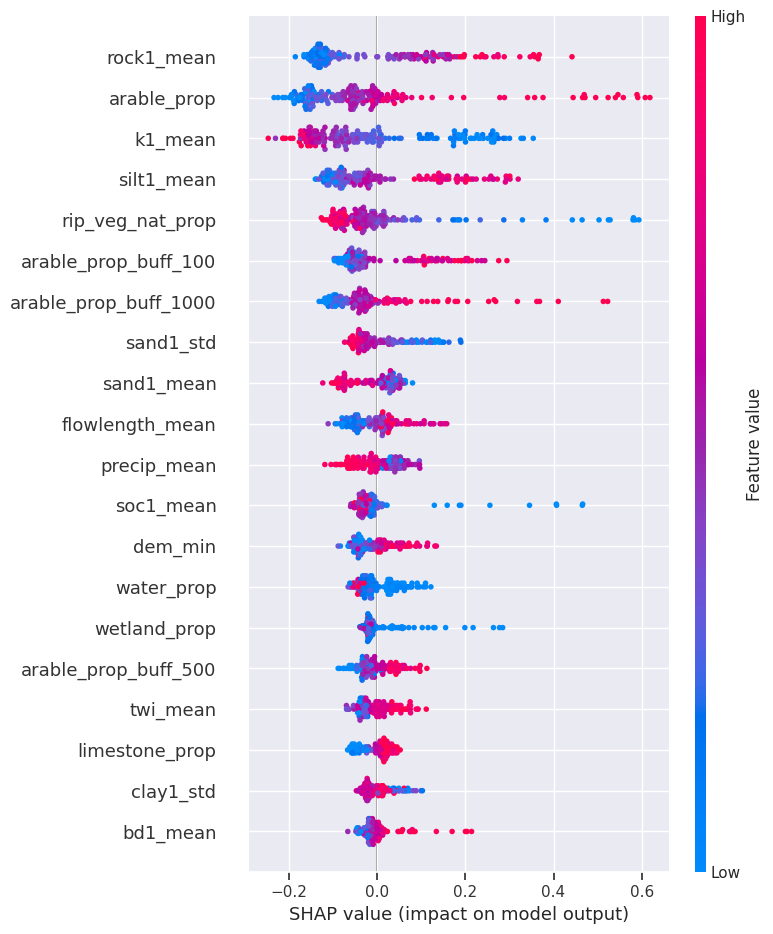

<Figure size 640x480 with 0 Axes>

In [23]:
# SHAP summary beeswarm plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns)
plt.tight_layout()

# Reduce number of features based on SHAP values

In [24]:
# Create DataFrame of absolute mean SHAP values
abs_mean_shap_df = pd.DataFrame(
    list(zip(X_test.columns, np.abs(shap_values).mean(0))), columns=["feature", "abs_mean_shap"]
)

In [25]:
# Sort based on absolute mean SHAP values
abs_mean_shap_df = abs_mean_shap_df.sort_values(by=["abs_mean_shap"], ascending=False).reset_index(drop=True)

In [26]:
abs_mean_shap_df

,feature,abs_mean_shap
0,rock1_mean,0.133190
1,arable_prop,0.130460
2,k1_mean,0.129173
3,silt1_mean,0.100473
4,rip_veg_nat_prop,0.087270
...,...,...
77,slope_min,0.000000
78,flowlength_min,0.000000
79,rock1_max,0.000000
80,rock1_min,0.000000


In [27]:
# List of most important features
n_features = 10
top_features = abs_mean_shap_df["feature"].head(n_features).to_list()
print(top_features)

['rock1_mean', 'arable_prop', 'k1_mean', 'silt1_mean', 'rip_veg_nat_prop', 'arable_prop_buff_100', 'arable_prop_buff_1000', 'sand1_std', 'sand1_mean', 'flowlength_mean']


In [28]:
# Generate new training and test feature sets
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Train model on reduced data

In [29]:
%%time

# Perform search for hyperparameters
params_reduced = search_hyperparams(X_train, y_train, random_state)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 1.21 s, sys: 116 ms, total: 1.33 s
Wall time: 42.3 s


In [30]:
# RF regressor
regressor_reduced = RandomForestRegressor()

# Set hyperparameters
regressor_reduced.set_params(**params_reduced)

# Fit model
regressor_reduced.fit(X_train_reduced, y_train)

RandomForestRegressor(max_depth=40, max_features='log2', min_samples_leaf=2,
                      n_estimators=60, oob_score=True)

In [31]:
# Calculate accuracy on training set
regressor_reduced.score(X_train_reduced, y_train)

0.8917722344919816

In [32]:
# Predict
Y_train_pred_reduced = regressor_reduced.predict(X_train_reduced)
Y_test_pred_reduced = regressor_reduced.predict(X_test_reduced)

In [33]:
# Calculate accuracy on test set
r2_score(y_test, Y_test_pred_reduced)

0.644196040063748

# SHAP analysis of the new model

In [34]:
# Calculate SHAP values
explainer_reduced = shap.TreeExplainer(regressor_reduced)
shap_values_reduced = shap.TreeExplainer(regressor_reduced).shap_values(X_train_reduced)

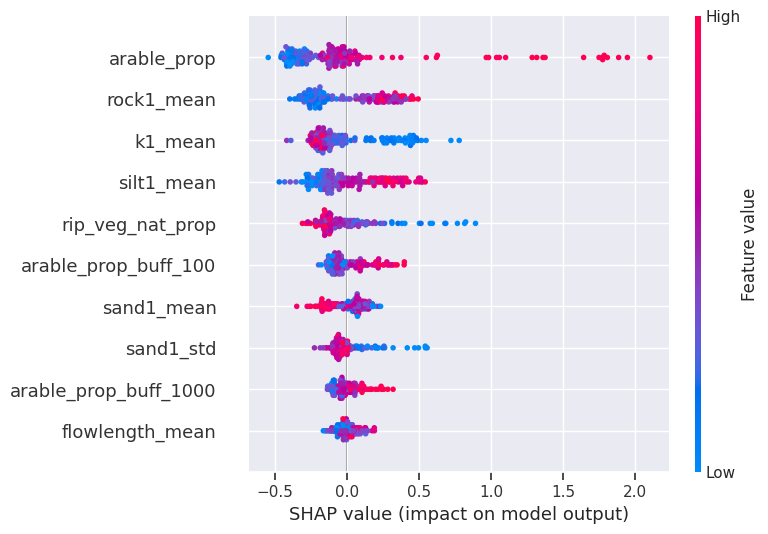

<Figure size 640x480 with 0 Axes>

In [35]:
# SHAP summary beeswarm plot
shap.summary_plot(shap_values=shap_values_reduced, features=X_train_reduced, feature_names=X_train_reduced.columns)
plt.tight_layout()

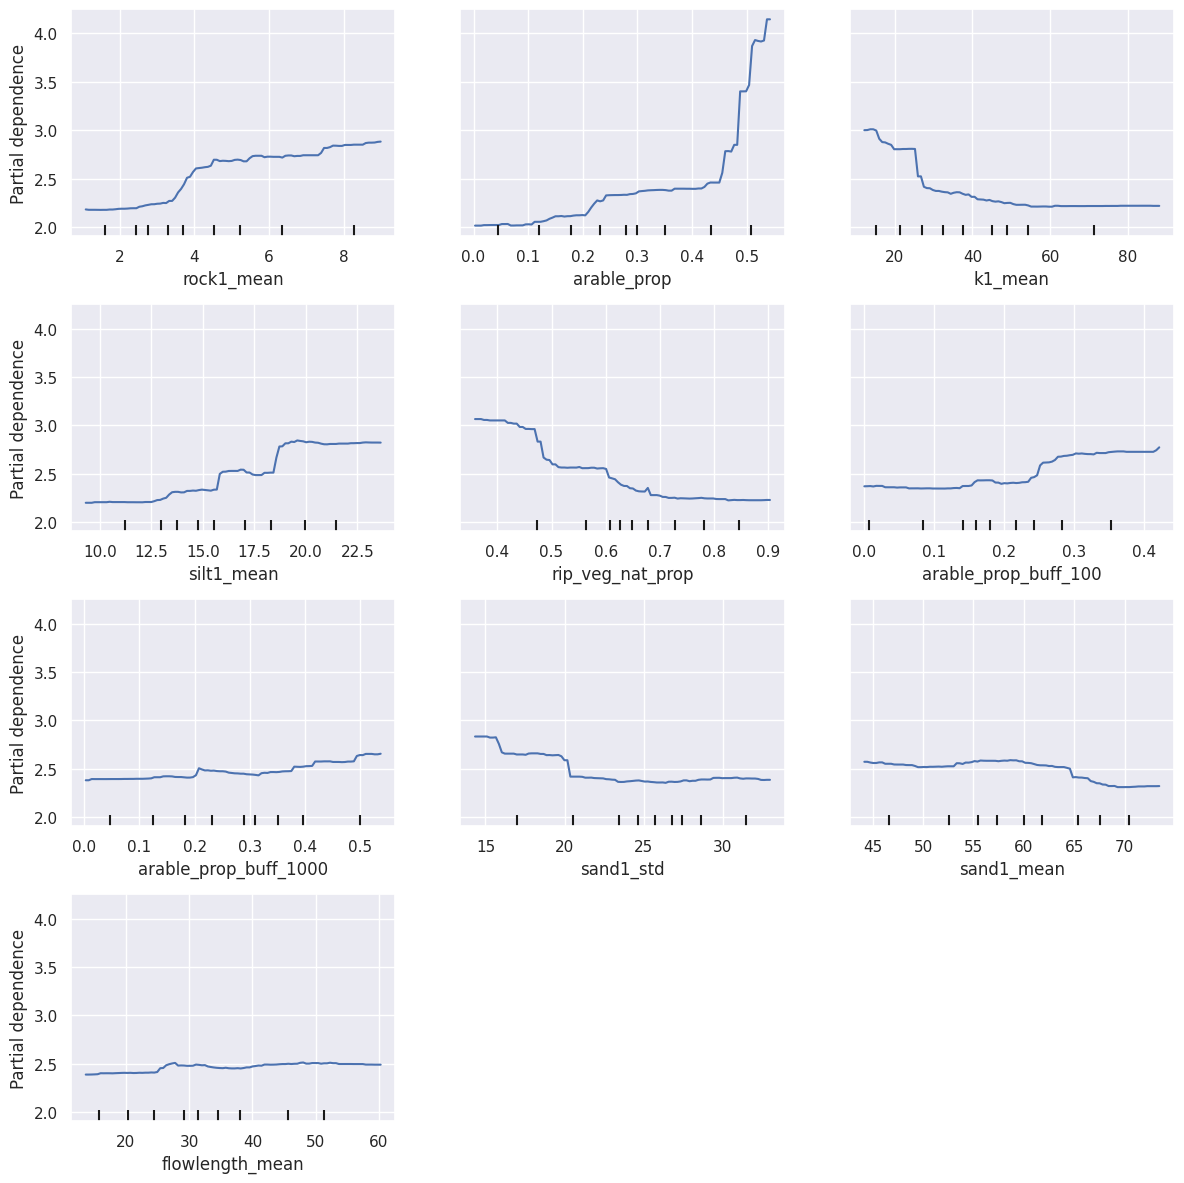

In [36]:
# Create partial dependence plot
fig, ax = plt.subplots(figsize=(12, 12))
disp = PartialDependenceDisplay.from_estimator(regressor_reduced, X_train_reduced, X_train_reduced.columns, ax=ax)
fig.subplots_adjust(hspace=0.3)
fig.tight_layout()